In [1]:
! pip install numpy matplotlib opencv-python torchvision scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 6.5 MB/s eta 0:00:00a 0:00:01


100.0%
100.0%
100.0%
100.0%


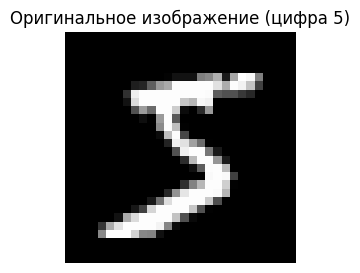

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import torchvision
import torchvision.transforms as transforms

# Загружаем MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Берем одно изображение для примера
image, label = mnist_dataset[0]
image = image.numpy().squeeze()  # Преобразуем тензор в numpy

# Визуализируем оригинальное изображение
plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray")
plt.title(f"Оригинальное изображение (цифра {label})")
plt.axis("off")
plt.show()

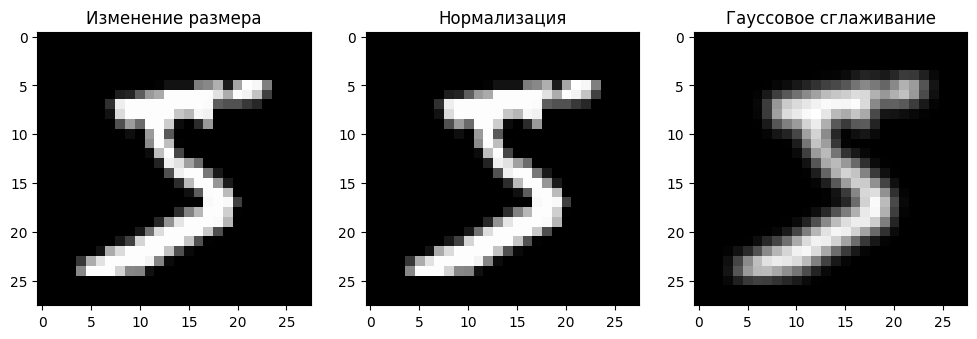

In [3]:
# Изменение размера (если требуется, но у MNIST уже 28x28)
resized_image = cv2.resize(image, (28, 28))

# Нормализация (приводим к диапазону 0-1)
normalized_image = resized_image / 255.0

# Устранение шумов с помощью Гауссового фильтра
denoised_image = cv2.GaussianBlur(normalized_image, (3, 3), 0)

# Визуализируем обработанное изображение
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(resized_image, cmap="gray")
plt.title("Изменение размера")

plt.subplot(1, 3, 2)
plt.imshow(normalized_image, cmap="gray")
plt.title("Нормализация")

plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap="gray")
plt.title("Гауссовое сглаживание")
plt.show()

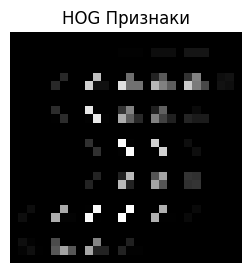

In [4]:
# Параметры HOG
hog_features, hog_image = hog(denoised_image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9,
                              visualize=True, block_norm='L2-Hys')

# Визуализируем HOG
plt.figure(figsize=(6, 3))
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Признаки")
plt.axis("off")
plt.show()

/Users/diemvs/anaconda3/envs/cv/lib/python3.10/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


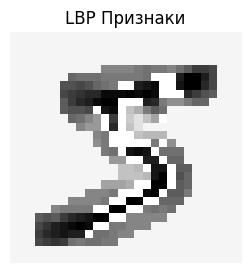

In [5]:
# Параметры LBP
radius = 3  # Радиус круга
n_points = 8 * radius  # Количество соседей
lbp_image = local_binary_pattern(denoised_image, P=n_points, R=radius, method="uniform")

# Визуализируем LBP
plt.figure(figsize=(6, 3))
plt.imshow(lbp_image, cmap="gray")
plt.title("LBP Признаки")
plt.axis("off")
plt.show()

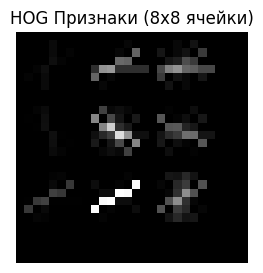

In [6]:
hog_features_large, hog_image_large = hog(denoised_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9,
                                          visualize=True, block_norm='L2-Hys')

plt.figure(figsize=(6, 3))
plt.imshow(hog_image_large, cmap="gray")
plt.title("HOG Признаки (8x8 ячейки)")
plt.axis("off")
plt.show()

In [8]:
! pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [1]:
import numpy as np
import torchvision
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Загружаем MNIST без трансформаций (оставляем данные как есть)
dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True)

# Функция для извлечения HOG признаков
def extract_hog_features(images):
    features = []
    for img in images:
        img = np.array(img)  # Преобразуем PIL-изображение в numpy
        img = img / 255.0  # Нормализация
        hog_feat = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        features.append(hog_feat)
    return np.array(features)

# Берем 5000 изображений
X = extract_hog_features([dataset[i][0] for i in range(5000)])  # dataset[i][0] — это изображение
y = np.array([int(dataset[i][1]) for i in range(5000)])  # dataset[i][1] — это метка класса

# Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

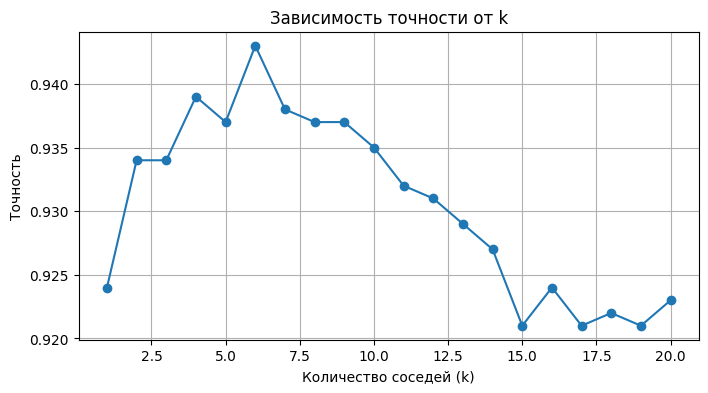

Оптимальное k: 6, точность: 0.9430


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")  # Можно поменять на "manhattan"
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Строим график
plt.figure(figsize=(8, 4))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.xlabel("Количество соседей (k)")
plt.ylabel("Точность")
plt.title("Зависимость точности от k")
plt.grid()
plt.show()

# Оптимальное k
best_k = k_values[np.argmax(accuracies)]
print(f"Оптимальное k: {best_k}, точность: {max(accuracies):.4f}")